In [ ]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram
import copy
from fennet.mhc.mhc_binding_model import *
from fennet.mhc.mhc_binding_retriever import MHCBindingRetriever
import pickle
import pandas as pd

In [18]:
hla_model_pt = "HLA_model_v0819.pt"
pept_model_pt = "pept_model_v0819.pt"

pept_encoder = ModelSeqEncoder().to("cuda")
hla_encoder = ModelHlaEncoder().to("cuda")
hla_encoder.load_state_dict(torch.load(f"model/{hla_model_pt}", map_location="cuda"))
pept_encoder.load_state_dict(torch.load(f"model/{pept_model_pt}", map_location="cuda"))

with open(f"embeds/hla_v0819_embeds.pkl", "rb") as f:
    data_dict = pickle.load(f)
    hla_df = data_dict["protein_df"]
    hla_embeds = data_dict["embeds"]

known_allele_df = pd.read_table("known_allele_list.txt", index_col=False)
hla_df = hla_df[hla_df["allele"].isin(known_allele_df["allele"])]
hla_df = hla_df.drop_duplicates(subset=["allele"])
hla_embeds = hla_embeds[hla_df.index.values]

fasta_list = ["uniprotkb_UP000005640_AND_reviewed_true_2024_03_01.fasta"]

retriever = MHCBindingRetriever(
    hla_encoder, pept_encoder, hla_df, hla_embeds, fasta_list
)

In [3]:
def get_mean_embeds(alleles, weights=None):
    selected_embeds = retriever.hla_embeds[
        [retriever.dataset.allele_idxes_dict[allele][0] for allele in alleles]
    ].copy()
    if weights is None:
        return np.mean(selected_embeds, axis=0)
    else:
        weights = (np.array(weights, np.float32) / np.sum(weights))[None, :]
        return weights @ selected_embeds

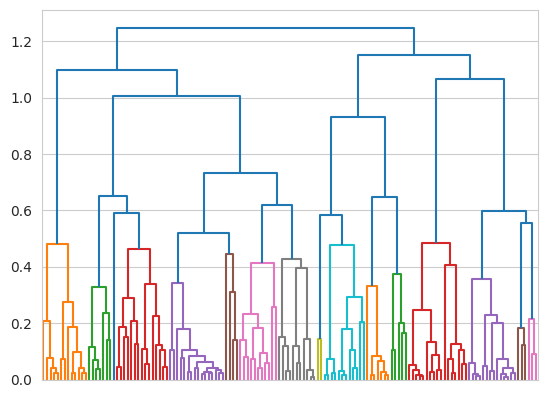

In [19]:
Z = linkage(hla_embeds, "complete")

# 确定切割高度
cut_height = 0.5

# 使用切割高度获取聚类标签
clusters = fcluster(Z, cut_height, criterion="distance")

# 绘制树状图
tree = dendrogram(Z, color_threshold=0.5, no_labels=True)

leaf_indices = tree["leaves"]

In [20]:
reordered_alleles = [hla_df.allele.values[i] for i in leaf_indices]
reordered_hla_embeds = copy.deepcopy(hla_embeds[leaf_indices, :])

In [21]:
reorder_list = []
start_idx = 0
for i in range(max(clusters)):
    tmp_num = len(np.where(clusters == i + 1)[0])
    reorder_list.append(reordered_alleles[start_idx : start_idx + tmp_num])
    start_idx += tmp_num

In [22]:
for i in range(len(reorder_list)):
    print(len(reorder_list[i]))

13
7
15
1
16
4
11
11
2
12
7
5
17
14
3
3


In [30]:
pep_list = retriever.dataset.digest.get_peptide_seqs_from_idxes(
    np.arange(0, len(retriever.dataset.digest.digest_starts))
)
len(pep_list)

73348991

In [23]:
cluster_mean_embeds_matrix = []
for i in range(len(reorder_list)):
    tmp_allele_list = reorder_list[i]
    cluster_mean_embeds_matrix.append(get_mean_embeds(tmp_allele_list))
cluster_mean_embeds_matrix = np.array(cluster_mean_embeds_matrix)
cluster_mean_embeds_matrix.shape

(16, 480)

In [24]:
dist_matrix = retriever.get_embedding_distances(
    cluster_mean_embeds_matrix, cluster_mean_embeds_matrix
)
dist_matrix

array([[0.        , 0.9050956 , 0.7653417 , 0.7109233 , 0.92279255,
        0.92960435, 0.8553794 , 0.9581455 , 1.1499199 , 1.0481983 ,
        1.0179785 , 0.9005225 , 1.006841  , 1.0311601 , 0.8985502 ,
        0.91138107],
       [0.9050956 , 0.        , 0.41643757, 0.4349788 , 0.7287447 ,
        0.5409742 , 0.40683505, 0.6195482 , 1.1406194 , 0.9220562 ,
        0.7987838 , 0.7466083 , 0.902519  , 0.8784374 , 0.5724331 ,
        0.7619099 ],
       [0.7653417 , 0.41643757, 0.        , 0.13297783, 0.77824634,
        0.6894771 , 0.3566598 , 0.6192176 , 1.0550495 , 0.8199752 ,
        0.6435109 , 0.59265935, 0.75972784, 0.7634762 , 0.41077325,
        0.6567574 ],
       [0.7109233 , 0.4349788 , 0.13297783, 0.        , 0.7166978 ,
        0.64963716, 0.3498908 , 0.5949974 , 1.0633063 , 0.8557073 ,
        0.7012987 , 0.6094273 , 0.7351853 , 0.72603804, 0.38864622,
        0.6002626 ],
       [0.92279255, 0.7287447 , 0.77824634, 0.7166978 , 0.        ,
        0.2981915 , 0.5406525 , 

In [25]:
df = pd.DataFrame(np.round(dist_matrix, decimals=2))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.00,0.91,0.77,0.71,0.92,0.93,0.86,0.96,1.15,1.05,1.02,0.90,1.01,1.03,0.90,0.91
1,0.91,0.00,0.42,0.43,0.73,0.54,0.41,0.62,1.14,0.92,0.80,0.75,0.90,0.88,0.57,0.76
2,0.77,0.42,0.00,0.13,0.78,0.69,0.36,0.62,1.06,0.82,0.64,0.59,0.76,0.76,0.41,0.66
3,0.71,0.43,0.13,0.00,0.72,0.65,0.35,0.59,1.06,0.86,0.70,0.61,0.74,0.73,0.39,0.60
4,0.92,0.73,0.78,0.72,0.00,0.30,0.54,0.34,0.99,0.86,0.82,0.71,0.91,0.86,0.78,0.52
5,0.93,0.54,0.69,0.65,0.30,0.00,0.45,0.40,0.92,0.77,0.80,0.65,0.84,0.87,0.74,0.56
6,0.86,0.41,0.36,0.35,0.54,0.45,0.00,0.32,0.91,0.67,0.55,0.42,0.83,0.66,0.39,0.43
7,0.96,0.62,0.62,0.59,0.34,0.40,0.32,0.00,0.93,0.71,0.56,0.51,0.92,0.73,0.60,0.42
8,1.15,1.14,1.06,1.06,0.99,0.92,0.91,0.93,0.00,0.41,0.90,0.58,0.90,0.90,0.98,0.76
9,1.05,0.92,0.82,0.86,0.86,0.77,0.67,0.71,0.41,0.00,0.54,0.30,0.88,0.91,0.85,0.69


In [26]:
output_file = "data/fig3a_between_cluster_dist_info.xlsx"
df.to_excel(output_file, index=False, header=False)

In [30]:
return_df = retriever.get_binding_distances(cluster_mean_embeds_matrix, pep_list)
return_df.shape

(73348991, 16)

In [31]:
indices = [np.where(return_df[:, col] <= 0.2)[0] for col in range(return_df.shape[1])]

In [32]:
num_cols = return_df.shape[1]
intersection_matrix = np.zeros((num_cols, num_cols), dtype=int)

for i in range(num_cols):
    for j in range(i, num_cols):
        common_count = len(np.intersect1d(indices[i], indices[j]))
        intersection_matrix[i, j] = common_count
        intersection_matrix[j, i] = common_count
intersection_matrix

array([[1052584,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0],
       [      0,  344807,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0],
       [      0,       0,  395778,  138079,       0,       0,    1364,
              0,       0,       0,       0,       0,       0,       0,
              0,       0],
       [      0,       0,  138079,  159839,       0,       0,     283,
              0,       0,       0,       0,       0,       0,       0,
              0,       0],
       [      0,       0,       0,       0,  737130,   23833,       0,
           4577,       0,       0,       0,       0,       0,       0,
              0,       0],
       [      0,       0,       0,       0,   23833,  160179,       0,
              0,       0,       0,       0,       0,       0,       0,
             

In [33]:
df = pd.DataFrame(intersection_matrix)

output_file = "data/fig3a_intersection_info.xlsx"
df.to_excel(output_file, index=False, header=False)

In [27]:
reordered_hla_embeds.shape

(141, 480)

In [28]:
reordered_alleles

['A30_01',
 'A03_01',
 'A11_01',
 'A03_02',
 'A11_02',
 'A74_01',
 'A31_01',
 'A34_02',
 'A33_01',
 'A33_03',
 'A68_01',
 'A34_01',
 'A66_01',
 'B58_02',
 'B57_01',
 'B57_03',
 'B58_01',
 'B15_13',
 'A32_01',
 'B15_17',
 'B15_03',
 'A01_01',
 'A36_01',
 'A30_02',
 'A80_01',
 'A29_02',
 'B15_01',
 'B15_02',
 'B15_11',
 'B35_01',
 'B35_08',
 'A26_03',
 'A26_08',
 'A25_01',
 'A26_01',
 'A26_02',
 'A68_02',
 'A69_01',
 'A02_07',
 'A02_17',
 'A02_19',
 'A02_06',
 'A02_05',
 'A02_03',
 'A02_50',
 'A02_16',
 'A02_02',
 'A02_01',
 'A02_12',
 'A02_04',
 'A02_11',
 'A02_20',
 'B52_01',
 'C15_02',
 'B13_01',
 'B13_02',
 'B46_01',
 'C12_04',
 'C12_02',
 'C12_03',
 'C02_02',
 'C16_02',
 'C15_05',
 'C16_01',
 'C03_02',
 'B48_01',
 'C07_04',
 'C08_01',
 'C17_01',
 'C03_04',
 'C03_03',
 'C04_03',
 'C05_01',
 'C08_02',
 'C01_02',
 'G01_03',
 'G01_04',
 'G01_01',
 'B73_01',
 'B39_06',
 'B27_05',
 'B27_03',
 'B27_09',
 'B27_04',
 'B39_05',
 'B38_01',
 'B38_02',
 'B39_24',
 'B39_01',
 'B15_10',
 'B15_18',

In [29]:
selected_embeds = retriever.hla_embeds[
    [
        retriever.dataset.allele_idxes_dict[allele][0]
        for allele in reordered_alleles[:13]
    ]
].copy()
selected_embeds.shape

(13, 480)

In [31]:
return_df = retriever.get_binding_distances(selected_embeds, pep_list)

In [32]:
indices = [np.where(return_df[:, col] <= 0.2)[0] for col in range(return_df.shape[1])]
num_cols = return_df.shape[1]
intersection_matrix = np.zeros((num_cols, num_cols), dtype=int)

for i in range(num_cols):
    for j in range(i, num_cols):
        common_count = len(np.intersect1d(indices[i], indices[j]))
        intersection_matrix[i, j] = common_count
        intersection_matrix[j, i] = common_count
intersection_matrix

array([[467857, 457703, 446558, 446214, 446231,  27333,   2979,   1989,
             0,      0,      0,      0,      0],
       [457703, 852096, 806265, 828448, 819880, 221825, 145681, 133381,
             0,      0,  22711,   1322,  11035],
       [446558, 806265, 908650, 881156, 897685, 296037, 241485, 212226,
         19669,  32077,  89424,  55444,  72441],
       [446214, 828448, 881156, 910030, 899317, 285001, 219865, 188923,
          4327,  13261,  67710,  35497,  51442],
       [446231, 819880, 897685, 899317, 925459, 305375, 244876, 204693,
         12351,  24119,  81093,  46766,  63825],
       [ 27333, 221825, 296037, 285001, 305375, 537060, 449444, 269798,
        110610, 128174, 170216, 120531, 144519],
       [  2979, 145681, 241485, 219865, 244876, 449444, 848449, 633073,
        489231, 512484, 563763, 510764, 536433],
       [  1989, 133381, 212226, 188923, 204693, 269798, 633073, 816754,
        597084, 617517, 685965, 636892, 661757],
       [     0,      0,  19669, 

In [33]:
df = pd.DataFrame(intersection_matrix)

output_file = "data/fig3a_cluster1_within_cluster_overlap_info.xlsx"
df.to_excel(output_file, index=False, header=False)

In [34]:
dist_matrix = retriever.get_embedding_distances(selected_embeds, selected_embeds)
df = pd.DataFrame(np.round(dist_matrix, decimals=2))
output_file = "data/fig3a_cluster1_within_cluster_dist_info.xlsx"
df.to_excel(output_file, index=False, header=False)